In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Models
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
# Chunk-based read
chunk_size = 500000  # half a million rows per chunk
csv_file = r"C:\Users\saran\OneDrive\Documents\STATS 295 ML Win 2025\Final Project\Motor_Vehicle_Collisions_-_Crashes_20250110.csv"

# Prepare a label encoder in advance
le = LabelEncoder()
all_chunks = []

for chunk in pd.read_csv(csv_file, chunksize=chunk_size, low_memory=False):

    # 1) Create severity score
    chunk['NUMBER OF PERSONS INJURED'] = chunk['NUMBER OF PERSONS INJURED'].fillna(0)
    chunk['NUMBER OF PERSONS KILLED'] = chunk['NUMBER OF PERSONS KILLED'].fillna(0)
    chunk['Severity_Score'] = chunk['NUMBER OF PERSONS INJURED'] + 10 * chunk['NUMBER OF PERSONS KILLED']
    # 2) Map severity class
    def map_severity_class(score):
        if score == 0:
            return "Minor"
        elif 1 <= score <= 2:
            return "Moderate"
        else:
            return "Severe"

    chunk['Severity_Class'] = chunk['Severity_Score'].apply(map_severity_class)

    # We'll encode later (after we combine all chunks)
    all_chunks.append(chunk)

# Concatenate all filtered chunks
df = pd.concat(all_chunks, ignore_index=True)

# 3) Encode severity class
df['Severity_Class_Encoded'] = le.fit_transform(df['Severity_Class'])

In [5]:
# Quick Data Inspection
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2147892 entries, 0 to 2147891
Data columns (total 32 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   CRASH DATE                     object 
 1   CRASH TIME                     object 
 2   BOROUGH                        object 
 3   ZIP CODE                       object 
 4   LATITUDE                       float64
 5   LONGITUDE                      float64
 6   LOCATION                       object 
 7   ON STREET NAME                 object 
 8   CROSS STREET NAME              object 
 9   OFF STREET NAME                object 
 10  NUMBER OF PERSONS INJURED      float64
 11  NUMBER OF PERSONS KILLED       float64
 12  NUMBER OF PEDESTRIANS INJURED  int64  
 13  NUMBER OF PEDESTRIANS KILLED   int64  
 14  NUMBER OF CYCLIST INJURED      int64  
 15  NUMBER OF CYCLIST KILLED       int64  
 16  NUMBER OF MOTORIST INJURED     int64  
 17  NUMBER OF MOTORIST KILLED      int64  
 18  CO

,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,COLLISION_ID,Severity_Score,Severity_Class_Encoded
count,1.908333e+06,1.908333e+06,2.147892e+06,2.147892e+06,2.147892e+06,2.147892e+06,2.147892e+06,2.147892e+06,2.147892e+06,2.147892e+06,2.147892e+06,2.147892e+06,2.147892e+06
mean,4.062002e+01,-7.373815e+01,3.195924e-01,1.542443e-03,5.814678e-02,7.630737e-04,2.795904e-02,1.205833e-04,2.292708e-01,6.341101e-04,3.213223e+06,3.350168e-01,2.565771e-01
std,2.056588e+00,3.852322e+00,7.080596e-01,4.144771e-02,2.472545e-01,2.818068e-02,1.669909e-01,1.102270e-02,6.692159e-01,2.754055e-02,1.507093e+06,8.255772e-01,4.797615e-01
min,0.000000e+00,-2.013600e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.200000e+01,0.000000e+00,0.000000e+00
25%,4.066755e+01,-7.397469e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.173093e+06,0.000000e+00,0.000000e+00
50%,4.072055e+01,-7.392705e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.710212e+06,0.000000e+00,0.000000e+00
75%,4.076962e+01,-7.386674e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.247416e+06,0.000000e+00,0.000000e+00
max,4.334444e+01,0.000000e+00,4.300000e+01,8.000000e+00,2.700000e+01,6.000000e+00,4.000000e+00,2.000000e+00,4.300000e+01,5.000000e+00,4.784641e+06,9.200000e+01,2.000000e+00


In [7]:
# Leverage the isnull() and sum() functions to find the number of missing values in each column
missing_values = df.isnull().sum()

# Turn the missing value counts into percentages
missing_values_percentage = (missing_values / len(df)) * 100

# Return counts and percentages of missing values in each column
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage (%)': missing_values_percentage})
missing_data.sort_values(by='Percentage (%)', ascending=False)

,Missing Values,Percentage (%)
VEHICLE TYPE CODE 5,2138581,99.566505
CONTRIBUTING FACTOR VEHICLE 5,2138285,99.552724
VEHICLE TYPE CODE 4,2113961,98.420265
CONTRIBUTING FACTOR VEHICLE 4,2112699,98.361510
VEHICLE TYPE CODE 3,1999012,93.068553
CONTRIBUTING FACTOR VEHICLE 3,1993184,92.797217
OFF STREET NAME,1778939,82.822553
CROSS STREET NAME,818965,38.128779
ZIP CODE,666058,31.009846
BOROUGH,665795,30.997601


In [9]:
# Drop columns with >40% missing
threshold = 0.4
cols_to_drop = [col for col in df.columns
                if df[col].isna().mean() > threshold]
df.drop(columns=cols_to_drop, inplace=True)

# Handle Missing Data

# Fill numeric columns with median
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Fill categorical columns with 'Unknown'
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col].fillna('Unknown', inplace=True)

In [11]:
# -------------------------------
# Fixed Transformations (Before the split)
# -------------------------------
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'], errors='coerce')
df['CRASH_YEAR'] = df['CRASH DATE'].dt.year
df['CRASH_MONTH'] = df['CRASH DATE'].dt.month
df['CRASH_DAY_OF_WEEK'] = df['CRASH DATE'].dt.dayofweek

# Create a "weekend" feature (1 if Sat or Sun, 0 otherwise)
df['IS_WEEKEND'] = df['CRASH_DAY_OF_WEEK'].isin([5, 6]).astype(int)

if 'CRASH TIME' in df.columns:
    df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME'], format='%H:%M')
    df['CRASH HOUR'] = df['CRASH TIME'].dt.hour
    df['CRASH MINUTE'] = df['CRASH TIME'].dt.minute
    df = df.drop(columns=['CRASH TIME'])
else:
    print("CRASH TIME column is missing, skipping time conversion.")

# VEHICLE TYPE CODE 1 – Mapping to Categories
df['VEHICLE TYPE CODE 1'] = df['VEHICLE TYPE CODE 1'].fillna('UNKNOWN')
vehicle_mapping = {
    "Sedan": "Passenger Vehicle",
    "4 dr sedan": "Passenger Vehicle",
    "Hatchback": "Passenger Vehicle",
    "Coupe": "Passenger Vehicle",
    "Sport Utility / Station Wagon": "SUV",
    "Station Wagon/Sport Utility Vehicle": "SUV",
    "Passenger Vehicle": "Passenger Vehicle",
    "Taxi": "Taxi",
    "TAXI": "Taxi",
    "Pick-up Truck": "Truck",
    "Box Truck": "Truck",
    "Delivery Truck": "Truck",
    "Motorcycle": "Motorcycle",
    "Bike": "Motorcycle",
    "Bus": "Bus",
    "Van": "Van",
    "UNKNOWN": "Other"
}
df['VEHICLE_TYPE_CATEGORY'] = df['VEHICLE TYPE CODE 1'].map(lambda x: vehicle_mapping.get(x, "Other"))

In [13]:
# Define the features
feature_cols = [
    'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
    'CRASH_YEAR', 'CRASH_MONTH', 'CRASH_DAY_OF_WEEK',
    'IS_WEEKEND', 'CRASH HOUR', 'CRASH MINUTE',
    'ON STREET NAME', 'CONTRIBUTING FACTOR VEHICLE 1',
    'VEHICLE_TYPE_CATEGORY'
]

X = df[feature_cols].copy()
y = df['Severity_Class_Encoded'].copy()

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1718313, 13)
y_train shape: (1718313,)
X_test shape: (429579, 13)
y_test shape: (429579,)


In [15]:
# -------------------------------
# Data-Dependent Feature Engineering (After the split)
# -------------------------------

# A. ON STREET NAME - Frequency Encoding
for dataset in [X_train, X_test]:
    dataset['ON STREET NAME'] = dataset['ON STREET NAME'].fillna('UNKNOWN')

# Learn frequencies from training data only:
street_counts_train = X_train['ON STREET NAME'].value_counts().to_dict()
X_train['ON_STREET_NAME_ENCODED'] = X_train['ON STREET NAME'].map(street_counts_train)
# Apply the same mapping to test set; unseen streets get 0
X_test['ON_STREET_NAME_ENCODED'] = X_test['ON STREET NAME'].map(street_counts_train).fillna(0).astype(int)

# B. CONTRIBUTING FACTOR VEHICLE 1 - Risk-Based Encoding
for dataset in [X_train, X_test]:
    dataset['CONTRIBUTING FACTOR VEHICLE 1'] = dataset['CONTRIBUTING FACTOR VEHICLE 1'].fillna('UNKNOWN')

# Learn risk scores from training data (normalized frequency)
factor_counts_train = X_train['CONTRIBUTING FACTOR VEHICLE 1'].value_counts()
risk_score_dict = (factor_counts_train / factor_counts_train.max()).to_dict()
X_train['CONTRIBUTING_FACTOR_RISK_SCORE'] = X_train['CONTRIBUTING FACTOR VEHICLE 1'].map(risk_score_dict)
X_test['CONTRIBUTING_FACTOR_RISK_SCORE'] = X_test['CONTRIBUTING FACTOR VEHICLE 1'].map(risk_score_dict).fillna(0)

# -------------------------------
# Feature Reduction / Encoding for High-Cardinality Columns
# -------------------------------
# For ZIP CODE: Instead of one-hot encoding, use frequency encoding.
for dataset in [X_train, X_test]:
    dataset['ZIP CODE'] = dataset['ZIP CODE'].fillna('UNKNOWN')

zip_counts_train = X_train['ZIP CODE'].value_counts().to_dict()
X_train['ZIP_CODE_FREQ'] = X_train['ZIP CODE'].map(zip_counts_train)
X_test['ZIP_CODE_FREQ'] = X_test['ZIP CODE'].map(zip_counts_train).fillna(0)

# Drop the raw 'ZIP CODE' column to avoid one-hot encoding it.
X_train = X_train.drop(columns=['ZIP CODE'])
X_test = X_test.drop(columns=['ZIP CODE'])

# -------------------------------
# Drop Raw Text Columns and One-Hot Encode Fixed Categorical Variables
# -------------------------------
# Drop the original raw columns that haven't been encoded:
X_train = X_train.drop(columns=['ON STREET NAME', 'CONTRIBUTING FACTOR VEHICLE 1'])
X_test = X_test.drop(columns=['ON STREET NAME', 'CONTRIBUTING FACTOR VEHICLE 1'])

# One-hot encode fixed categorical features: BOROUGH and VEHICLE_TYPE_CATEGORY.
X_train = pd.get_dummies(X_train, columns=['BOROUGH', 'VEHICLE_TYPE_CATEGORY'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['BOROUGH', 'VEHICLE_TYPE_CATEGORY'], drop_first=True)

# Ensure the test set has the same dummy columns as the training set.
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [ ]:
# -------------------------------
# Model Training & Comparison
# -------------------------------

# Baseline Model: Logistic Regression (Multinomial) class weight balanced

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

import time

# Start timer
log_train_start = time.time()

# Initialize and fit logistic regression with class weighting
log_clf = LogisticRegression(
    multi_class='multinomial',
    solver='saga',  # supports L1/L2 penalty
    max_iter=2000, class_weight='balanced'
)
log_clf.fit(X_train_scaled, y_train)

# End timer
log_train_end = time.time()

# Calculate elapsed time
log_training_time = log_train_end - log_train_start

# Make predictions
log_pred_start = time.time()
y_pred_log = log_clf.predict(X_test_scaled)
log_pred_end = time.time()
log_prediction_time = log_pred_end - log_pred_start

# Evaluate performance
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))
print(f"Logistic training time: {log_training_time:.2f} seconds")
print(f"Logistic prediction time: {log_prediction_time:.2f} seconds")

C:\Users\saran\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression Accuracy: 0.4666382667681614
              precision    recall  f1-score   support

           0       0.84      0.52      0.64    327827
           1       0.34      0.27      0.30     93284
           2       0.03      0.54      0.06      8468

    accuracy                           0.47    429579
   macro avg       0.40      0.44      0.33    429579
weighted avg       0.71      0.47      0.56    429579

Logistic training time: 15022.46 seconds
Logistic prediction time: 0.47 seconds


In [ ]:
# -------------------------------
# Logistic Regression (Grid Search) class weight balanced
# -------------------------------

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Baseline Model: Logistic Regression (Multinomial)
# Build Pipeline & GridSearchCV
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_clf', LogisticRegression(
        multi_class='multinomial',
        solver='saga',          # supports L1/L2 penalty
        max_iter=10000,         # increased max_iter
        class_weight='balanced'
    ))
])
# Define the hyperparameter grid to tune
param_grid = {
    'log_clf__C': [0.01, 0.1, 1, 10, 100],
    'log_clf__penalty': ['l1', 'l2']
}
# Initialize GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1,
    error_score='raise'  # to debug any errors
)

# Time the grid search training process
train_start = time.time()
grid_search.fit(X_train, y_train)
train_end = time.time()
grid_training_time = train_end - train_start

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Time the prediction process
pred_start = time.time()
y_pred = grid_search.predict(X_test)
pred_end = time.time()
grid_prediction_time = pred_end - pred_start

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f"GridSearch Training time: {grid_training_time:.2f} seconds")
print(f"Prediction time: {grid_prediction_time:.2f} seconds")

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\saran\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Parameters: {'log_clf__C': 0.1, 'log_clf__penalty': 'l1'}
Best Cross-Validation Score: 0.4867820938327301
Test Accuracy: 0.482821553195105
              precision    recall  f1-score   support

           0       0.83      0.54      0.65    327827
           1       0.34      0.28      0.31     93284
           2       0.03      0.48      0.06      8468

    accuracy                           0.48    429579
   macro avg       0.40      0.43      0.34    429579
weighted avg       0.71      0.48      0.57    429579

GridSearch Training time: 36776.62 seconds
Prediction time: 0.51 seconds


In [ ]:
# --------------------------------------------------
# Baseline Model: Logistic Regression (Randomized Search)
# --------------------------------------------------

# Define the hyperparameter space
param_dist = {
    "C": np.logspace(-4, 4, 20),  # Regularization strength
    "penalty": ["l1", "l2"],       # Regularization type (only "l2" works with saga)
    "solver": ["liblinear", "saga"],  # Solvers suitable for l1 & l2 penalties
}

# Initialize the model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    log_reg, param_distributions=param_dist,
    n_iter=30,  # Number of different hyperparameter combinations to try
    cv=5,       # Cross-validation folds
    scoring="accuracy",
    n_jobs=-1,  # Use all CPU cores
    random_state=42,
    verbose=1
)

# Train the model with RandomizedSearchCV
train_start = time.time()
random_search.fit(X_train, y_train)
train_end = time.time()
rand_training_time = train_end - train_start

# Print the best parameters and accuracy
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy Score:", random_search.best_score_)

# Use the best model to predict on test data
best_log_reg = random_search.best_estimator_

pred_start = time.time()
y_pred_best_log = best_log_reg.predict(X_test)
pred_end = time.time()
rand_prediction_time = pred_end - pred_start

# Evaluate performance
print("\nTest Accuracy:", accuracy_score(y_test, y_pred_best_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best_log))
print(f"RandomSearch Training time: {rand_training_time:.2f} seconds")
print(f"Prediction time: {rand_prediction_time:.2f} seconds")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.08858667904100823}
Best Accuracy Score: 0.7694186101751492

Test Accuracy: 0.76926246394726

Classification Report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87    327827
           1       0.75      0.04      0.08     93284
           2       0.00      0.00      0.00      8468

    accuracy                           0.77    429579
   macro avg       0.51      0.35      0.32    429579
weighted avg       0.75      0.77      0.68    429579

RandomSearch Training time: 8034.02 seconds
Prediction time: 0.05 seconds


C:\Users\saran\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saran\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saran\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# --------------------------------------------------
# Baseline Model: Logistic Regression (Randomized Search) class weight balanced
# --------------------------------------------------

# Define the hyperparameter space
param_dist = {
    "C": np.logspace(-4, 4, 20),  # Regularization strength
    "penalty": ["l1", "l2"],       # Regularization type (only "l2" works with saga)
    "solver": ["liblinear", "saga"],  # Solvers suitable for l1 & l2 penalties
}

# Initialize the model
log_reg = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    log_reg, param_distributions=param_dist,
    n_iter=30,  # Number of different hyperparameter combinations to try
    cv=5,       # Cross-validation folds
    scoring="accuracy",
    n_jobs=-1,  # Use all CPU cores
    random_state=42,
    verbose=1
)

# Train the model with RandomizedSearchCV
train_start = time.time()
random_search.fit(X_train, y_train)
train_end = time.time()
rand_training_time = train_end - train_start

# Print the best parameters and accuracy
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy Score:", random_search.best_score_)

# Use the best model to predict on test data
best_log_reg = random_search.best_estimator_

pred_start = time.time()
y_pred_best_log = best_log_reg.predict(X_test)
pred_end = time.time()
rand_prediction_time = pred_end - pred_start

# Evaluate performance
print("\nTest Accuracy:", accuracy_score(y_test, y_pred_best_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best_log))
print(f"RandomSearch Training time: {rand_training_time:.2f} seconds")
print(f"Prediction time: {rand_prediction_time:.2f} seconds")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.00026366508987303583}
Best Accuracy Score: 0.7687662262494028

Test Accuracy: 0.7686572202086228

Classification Report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87    327827
           1       0.74      0.04      0.08     93284
           2       0.06      0.00      0.00      8468

    accuracy                           0.77    429579
   macro avg       0.52      0.35      0.32    429579
weighted avg       0.75      0.77      0.68    429579

RandomSearch Training time: 22114.27 seconds
Prediction time: 0.13 seconds


In [17]:
print("Training Set Class Distribution:")
print(np.bincount(y_train))

print("Test Set Class Distribution:")
print(np.bincount(y_test))

Training Set Class Distribution:
[1311306  373134   33873]
Test Set Class Distribution:
[327827  93284   8468]


In [ ]:
# --------------
# Decision Tree (Randomized Search) class weight balanced
# --------------

import matplotlib.colors as mcolors

# Define parameter distribution for Random Search
param_dist = {
    "max_depth": np.arange(5, 30, 5),  # Increase upper limit
    "min_samples_leaf": np.arange(10, 100, 10),
    "criterion": ["gini", "entropy"],
}

# Initialize Decision Tree Classifier
tree = DecisionTreeClassifier(random_state=42, class_weight="balanced")

# Perform Randomized Search
random_search = RandomizedSearchCV(
    tree, param_dist, n_iter=20, cv=5, scoring="accuracy",
    n_jobs=-1, random_state=42, verbose=1
)

# Fit Randomized Search to training data
train_start = time.time()
random_search.fit(X_train, y_train)
train_end = time.time()
tree_training_time = train_end - train_start

# Get best model from Randomized Search
best_tree_clf = random_search.best_estimator_

# Print best hyperparameters and accuracy from CV
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy Score (CV):", random_search.best_score_)

# Make predictions on test data
pred_start = time.time()
y_pred_best_tree = best_tree_clf.predict(X_test)
pred_end = time.time()
tree_prediction_time = pred_end - pred_start

# Evaluate model performance
print("\nTest Accuracy:", accuracy_score(y_test, y_pred_best_tree))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best_tree))
print(f"Decision Tree Randomized Search Training time: {tree_training_time:.2f} seconds")
print(f"Prediction time: {tree_prediction_time:.2f} seconds")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'min_samples_leaf': 50, 'max_depth': 5, 'criterion': 'entropy'}
Best Accuracy Score (CV): 0.6559491769701996

Test Accuracy: 0.6528415029598746

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.77      0.80    327827
           1       0.36      0.27      0.31     93284
           2       0.04      0.28      0.08      8468

    accuracy                           0.65    429579
   macro avg       0.41      0.44      0.39    429579
weighted avg       0.71      0.65      0.68    429579

Decision Tree Randomized Search Training time: 223.73 seconds
Prediction time: 0.09 seconds


Confusion Matrix: 
 [[252686  42855  32286]
 [ 50350  25421  17513]
 [  4463   1665   2340]]


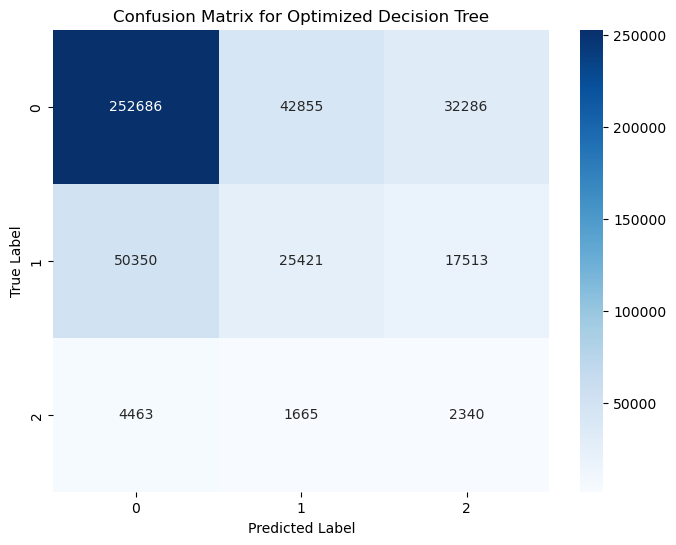

In [ ]:
# Compute confusion matrix for Decision Tree
cm_tree = confusion_matrix(y_test, y_pred_best_tree)
print("Confusion Matrix: \n", cm_tree)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tree, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Optimized Decision Tree")

plt.show()

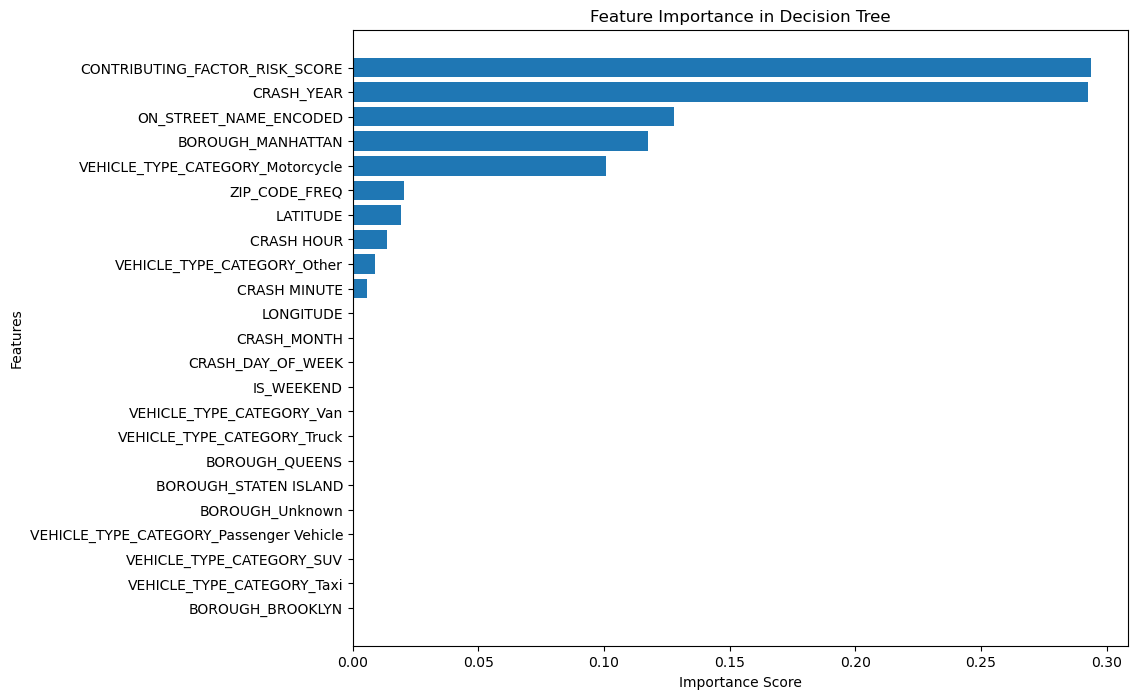

In [ ]:
# -------------------------------
# Extract Feature Importance
# -------------------------------

# Get feature importance scores
importances = best_tree_clf.feature_importances_

# Sort feature importance in descending order
indices = np.argsort(importances)[::-1]

# Get feature names
feature_names = X_train.columns  # Ensure X_train is a Pandas DataFrame

# Plot the feature importance
plt.figure(figsize=(10, 8))
plt.title("Feature Importance in Decision Tree")
plt.barh(range(len(importances)), importances[indices], align="center")
plt.yticks(range(len(importances)), feature_names[indices])
plt.xlabel("Importance Score")
plt.ylabel("Features")

plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

In [ ]:
# --------------
# Random Forest (Randomized Search) class weight balanced
# --------------

# Define hyperparameter search space
param_dist = {
    "n_estimators": np.arange(50, 100, 150),  # Number of trees
    "max_depth": [None, 10, 20, 30],  # Depth of trees
    "min_samples_split": np.arange(2, 4, 8),  # Min samples required to split
    "min_samples_leaf": np.arange(1, 2, 4),  # Min samples per leaf
    "bootstrap": [True, False],  # Bootstrap sampling
    "criterion": ["gini", "entropy"]
}

# Initialize the base Random Forest model
rf = RandomForestClassifier(random_state=42, class_weight="balanced")

# Perform Randomized Search
random_search_rf = RandomizedSearchCV(
    rf, param_dist, n_iter=10, cv=3, scoring="accuracy",
    n_jobs=-1, random_state=42, verbose=1
)

# Fit RandomizedSearchCV to training data
train_start = time.time()
random_search_rf.fit(X_train, y_train)
train_end = time.time()
rf_training_time = train_end - train_start

# Get best model
best_rf = random_search_rf.best_estimator_

# Print best hyperparameters
print("Best Parameters:", random_search_rf.best_params_)
print("Best Accuracy Score (CV):", random_search_rf.best_score_)

# Make predictions on test data
pred_start = time.time()
y_pred_best_rf = best_rf.predict(X_test)
pred_end = time.time()
rf_prediction_time = pred_end - pred_start

# Evaluate model performance
print("\nTest Accuracy:", accuracy_score(y_test, y_pred_best_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best_rf))
print(f"\nRandom Forest Training Time: {rf_training_time:.2f} seconds")
print(f"Random Forest Prediction Time: {rf_prediction_time:.2f} seconds")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'gini', 'bootstrap': True}
Best Accuracy Score (CV): 0.7734673484982073

Test Accuracy: 0.7739018899899669

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.98      0.87    327827
           1       0.60      0.12      0.21     93284
           2       0.38      0.00      0.01      8468

    accuracy                           0.77    429579
   macro avg       0.59      0.37      0.36    429579
weighted avg       0.74      0.77      0.71    429579


Random Forest Training Time: 997.21 seconds
Random Forest Prediction Time: 10.64 seconds


Confusion Matrix: 
 [[320802   6990     35]
 [ 81651  11622     11]
 [  7811    629     28]]


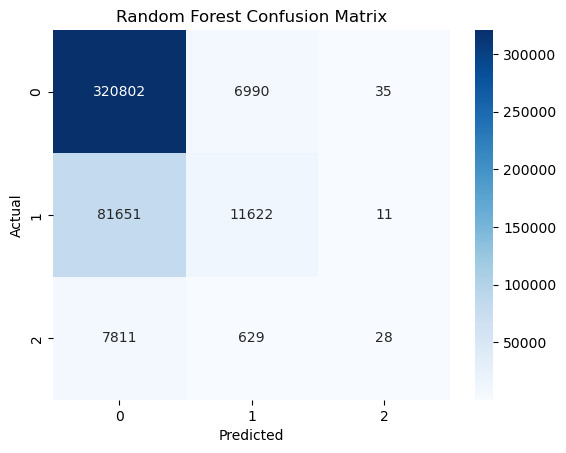

In [ ]:
# Compute confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_best_rf)
print("Confusion Matrix: \n", cm_rf)

# Plot Confusion Matrix
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")

plt.show()

In [ ]:
# --------
# XGBoost
# --------

xgb_clf = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

train_start = time.time()
xgb_clf.fit(X_train, y_train)
train_end = time.time()
xgb_training_time = train_end - train_start

# Make predictions
pred_start = time.time()
y_pred_xgb = xgb_clf.predict(X_test)
pred_end = time.time()
xgb_prediction_time = pred_end - pred_start

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print(f"XGBoost Training Time: {xgb_training_time:.2f} seconds")
print(f"XGBoost Prediction Time: {xgb_prediction_time:.2f} seconds")

XGBoost Accuracy: 0.782123893393299
              precision    recall  f1-score   support

           0       0.79      0.98      0.87    327827
           1       0.65      0.17      0.27     93284
           2       1.00      0.00      0.00      8468

    accuracy                           0.78    429579
   macro avg       0.81      0.38      0.38    429579
weighted avg       0.76      0.78      0.72    429579

XGBoost Training Time: 31.84 seconds
XGBoost Prediction Time: 0.85 seconds


Confusion Matrix: 
 [[320221   7606      0]
 [ 77522  15762      0]
 [  7575    892      1]]


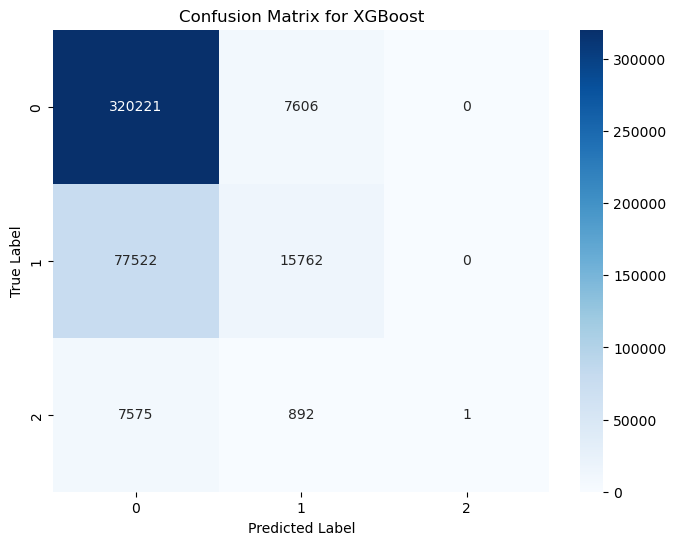

In [ ]:
# Plot Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix: \n", cm_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for XGBoost")
plt.show()

In [ ]:
# Compute scale_pos_weight for each class
class_counts = np.bincount(y_train)  # Get the count of each class
total_samples = len(y_train)  # Total number of samples

scale_pos_weight = total_samples / (len(class_counts) * class_counts)  # Compute weight per class

print("Scale Pos Weight for Each Class:", scale_pos_weight)

Scale Pos Weight for Each Class: [ 0.43679431  1.53502763 16.90936734]


In [ ]:
# --------
# XGBoost (w/ sample weights)
# --------

# Initialize XGBoost without `use_label_encoder`
xgb_clf = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softmax",  # Multi-class classification
    eval_metric="mlogloss",  # Use multi-class log loss
    random_state=42,
    n_jobs=-1
)

# Assign sample weights to each instance
sample_weights = np.array([scale_pos_weight[label] for label in y_train])

# Train the model with sample weights
train_start = time.time()
xgb_clf.fit(X_train, y_train, sample_weight=sample_weights)
train_end = time.time()
xgb_training_time = train_end - train_start

# Make predictions
pred_start = time.time()
y_pred_xgb = xgb_clf.predict(X_test)
pred_end = time.time()
xgb_prediction_time = pred_end - pred_start

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print(f"XGBoost Training Time: {xgb_training_time:.2f} seconds")
print(f"XGBoost Prediction Time: {xgb_prediction_time:.2f} seconds")

XGBoost Accuracy: 0.6013678508493199
              precision    recall  f1-score   support

           0       0.86      0.66      0.75    327827
           1       0.39      0.40      0.39     93284
           2       0.05      0.44      0.08      8468

    accuracy                           0.60    429579
   macro avg       0.43      0.50      0.41    429579
weighted avg       0.74      0.60      0.66    429579

XGBoost Training Time: 18.76 seconds
XGBoost Prediction Time: 0.43 seconds


XGBoost Confusion Matrix:
 [[217536  56574  53717]
 [ 33458  37031  22795]
 [  2431   2269   3768]]


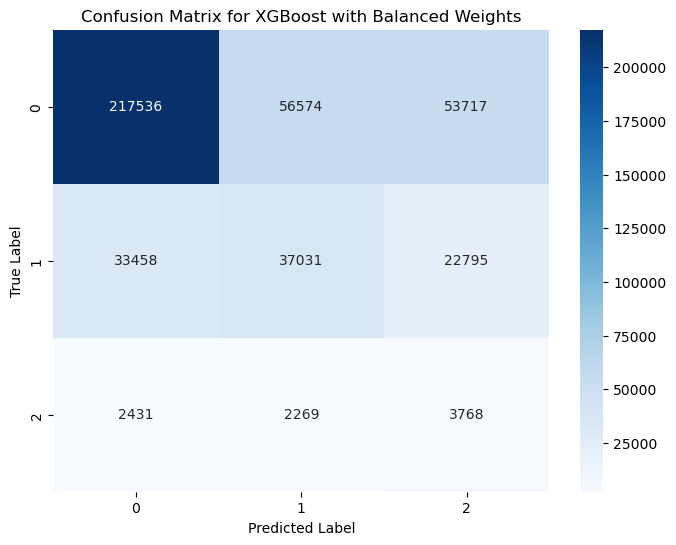

In [ ]:
# Compute confusion matrix
cm_xg = confusion_matrix(y_test, y_pred_xgb)
print("XGBoost Confusion Matrix:\n", cm_xg)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xg, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for XGBoost with Balanced Weights")
plt.show()

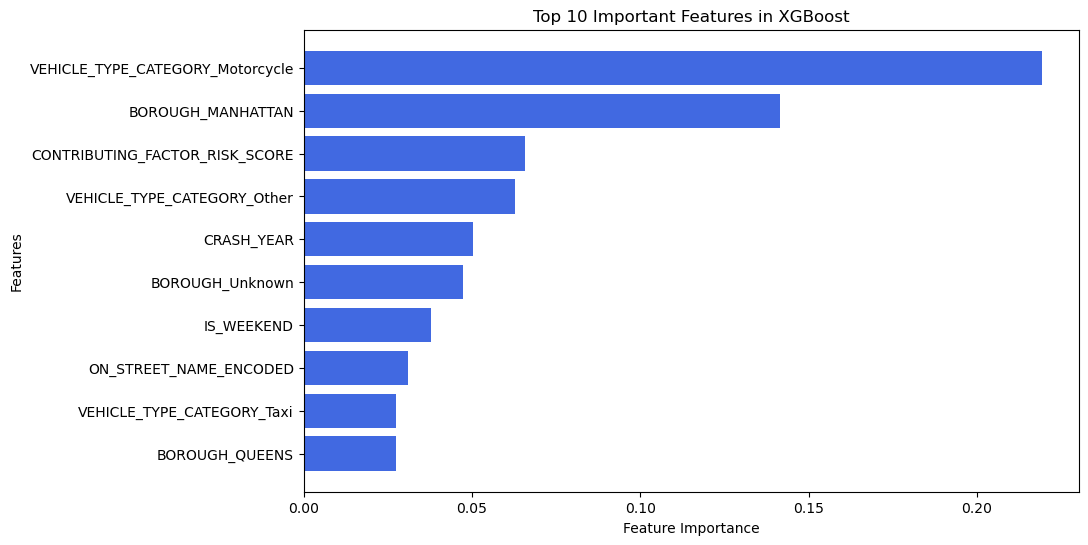

In [ ]:
# --------------------------
# Check Feature Importance
# --------------------------

feature_importance = xgb_clf.feature_importances_
feature_names = X_train.columns

sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[sorted_idx][-10:], feature_importance[sorted_idx][-10:], color='royalblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 10 Important Features in XGBoost")
plt.show()


In [ ]:
# --------------------------
# K-Nearest Neighbors (KNN)
# --------------------------

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

knn_clf = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

train_start = time.time()
knn_clf.fit(X_train_scaled, y_train)
train_end = time.time()
knn_training_time = train_end - train_start

pred_start = time.time()
y_pred_knn = knn_clf.predict(X_test_scaled)
pred_end = time.time()
knn_prediction_time = pred_end - pred_start

print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))
print(f"KNN Training Time: {knn_training_time:.2f} seconds")
print(f"KNN Prediction Time: {knn_prediction_time:.2f} seconds")

KNN Accuracy: 0.7444544542447373

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.93      0.85    327827
           1       0.39      0.17      0.24     93284
           2       0.02      0.00      0.00      8468

    accuracy                           0.74    429579
   macro avg       0.40      0.37      0.36    429579
weighted avg       0.68      0.74      0.70    429579

KNN Training Time: 0.24 seconds
KNN Prediction Time: 516.29 seconds


Confusion Matrix:
 [[303904  23855     68]
 [ 77357  15896     31]
 [  7306   1160      2]]


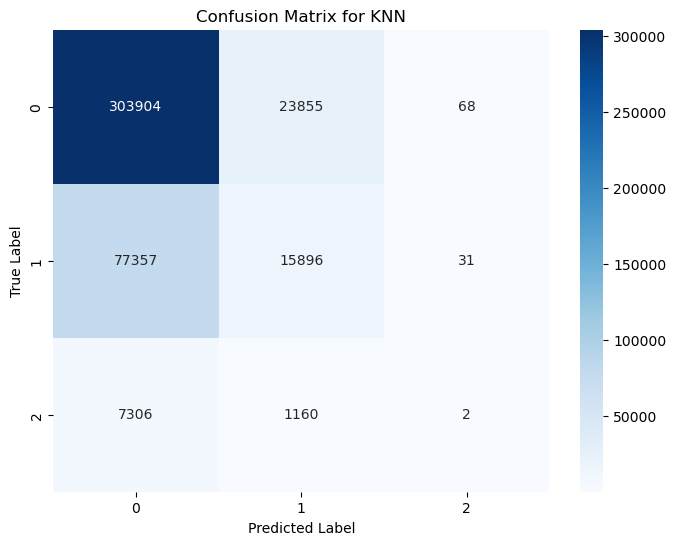

In [ ]:
# Plot Confusion Matrix for KNN
cm_knn = confusion_matrix(y_test, y_pred_knn)
print("Confusion Matrix:\n", cm_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for KNN")
plt.show()

In [ ]:
# ----------------------------
# KNN Using Distance Weighting
# ----------------------------

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

knn_clf = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)

train_start = time.time()
knn_clf.fit(X_train_scaled, y_train)
train_end = time.time()
knn_training_time = train_end - train_start

pred_start = time.time()
y_pred_knn = knn_clf.predict(X_test_scaled)
pred_end = time.time()
knn_prediction_time = pred_end - pred_start

print("KNN Using DW Accuracy:", accuracy_score(y_test, y_pred_knn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))
print(f"KNN Training Time: {knn_training_time:.2f} seconds")
print(f"KNN Prediction Time: {knn_prediction_time:.2f} seconds")

KNN Using DW Accuracy: 0.7283945444260543

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.90      0.84    327827
           1       0.36      0.20      0.26     93284
           2       0.05      0.01      0.02      8468

    accuracy                           0.73    429579
   macro avg       0.40      0.37      0.37    429579
weighted avg       0.68      0.73      0.69    429579

KNN Training Time: 0.18 seconds
KNN Prediction Time: 425.94 seconds


Confusion Matrix for KNN Using DW:
 [[294070  32547   1210]
 [ 74090  18746    448]
 [  6996   1385     87]]


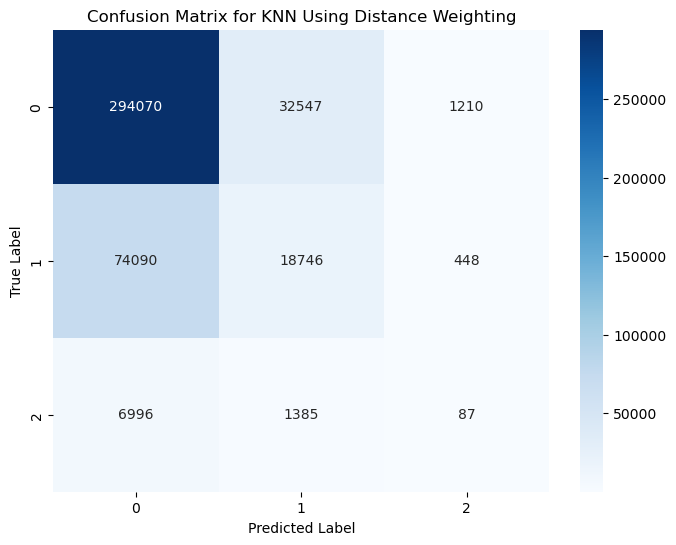

In [ ]:
# Plot Confusion Matrix for KNN Using Distance Weighting
cm_knn = confusion_matrix(y_test, y_pred_knn)
print("Confusion Matrix for KNN Using DW:\n", cm_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for KNN Using Distance Weighting")
plt.show()

In [19]:
# ------
# SMOTE
# ------
from imblearn.under_sampling import RandomUnderSampler

# Apply undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

# Check new class distribution
print("Balanced Training Set Class Distribution:", np.bincount(y_train_balanced))

Balanced Training Set Class Distribution: [33873 33873 33873]


In [ ]:
# --------
# XGBoost (SMOTE)
# --------

xgb_clf = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

train_start = time.time()
xgb_clf.fit(X_train_balanced, y_train_balanced)
train_end = time.time()
xgb_training_time = train_end - train_start

# Make predictions
pred_start = time.time()
y_pred_xgb = xgb_clf.predict(X_test)
pred_end = time.time()
xgb_prediction_time = pred_end - pred_start

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print(f"XGBoost Training Time: {xgb_training_time:.2f} seconds")
print(f"XGBoost Prediction Time: {xgb_prediction_time:.2f} seconds")

XGBoost Accuracy: 0.5419212764124876
              precision    recall  f1-score   support

           0       0.86      0.59      0.70    327827
           1       0.36      0.36      0.36     93284
           2       0.04      0.55      0.08      8468

    accuracy                           0.54    429579
   macro avg       0.42      0.50      0.38    429579
weighted avg       0.74      0.54      0.62    429579

XGBoost Training Time: 2.73 seconds
XGBoost Prediction Time: 0.45 seconds


Confusion Matrix: 
 [[194582  57762  75483]
 [ 28923  33594  30767]
 [  1989   1857   4622]]


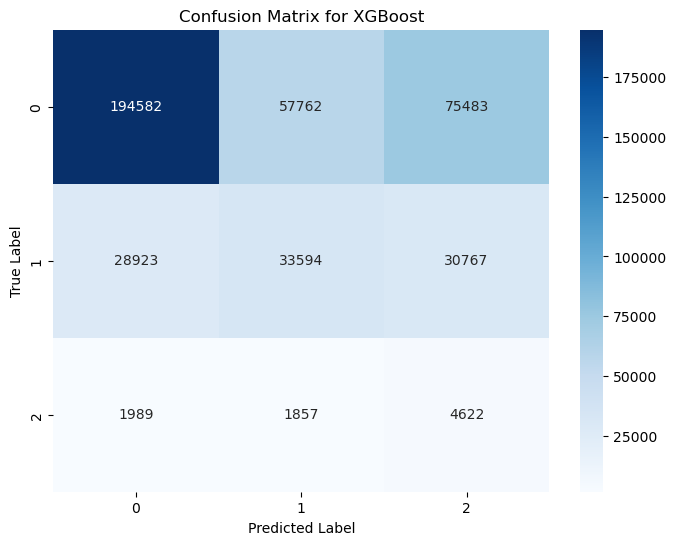

In [ ]:
# Plot Confusion Matrix (SMOTE)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix: \n", cm_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for XGBoost")
plt.show()

In [ ]:
# --------------------------
# K-Nearest Neighbors (KNN) (SMOTE)
# --------------------------

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled  = scaler.transform(X_test)

knn_clf = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

train_start = time.time()
knn_clf.fit(X_train_scaled, y_train_balanced)
train_end = time.time()
knn_training_time = train_end - train_start

pred_start = time.time()
y_pred_knn = knn_clf.predict(X_test_scaled)
pred_end = time.time()
knn_prediction_time = pred_end - pred_start

print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))
print(f"KNN Training Time: {knn_training_time:.2f} seconds")
print(f"KNN Prediction Time: {knn_prediction_time:.2f} seconds")

KNN Accuracy: 0.5001059176542615

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.55      0.65    327827
           1       0.27      0.36      0.31     93284
           2       0.03      0.29      0.05      8468

    accuracy                           0.50    429579
   macro avg       0.37      0.40      0.34    429579
weighted avg       0.68      0.50      0.56    429579

KNN Training Time: 0.00 seconds
KNN Prediction Time: 24.20 seconds


Confusion Matrix:
 [[178826  89554  59447]
 [ 38870  33563  20851]
 [  3375   2647   2446]]


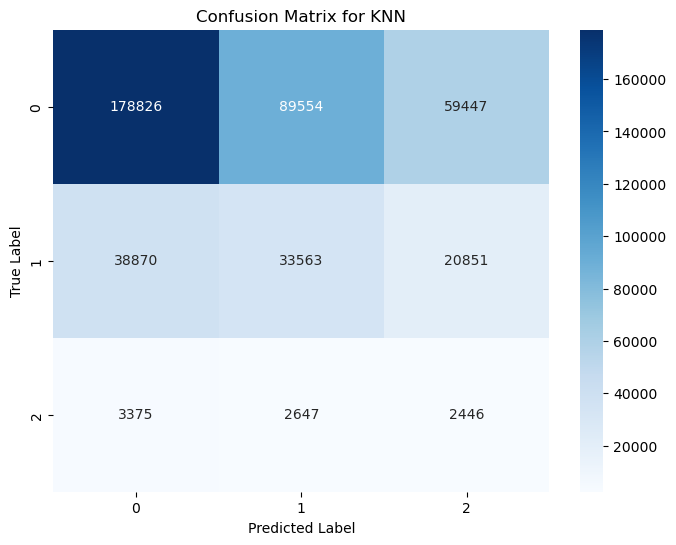

In [ ]:
# Plot Confusion Matrix for KNN (SMOTE)
cm_knn = confusion_matrix(y_test, y_pred_knn)
print("Confusion Matrix:\n", cm_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for KNN")
plt.show()

In [21]:
# --------------
# Random Forest (randomized + SMOTE)
# --------------

# Define hyperparameter search space
param_dist = {
    "n_estimators": np.arange(50, 100, 150),  # Number of trees
    "max_depth": [None, 10, 20, 30],  # Depth of trees
    "min_samples_split": np.arange(2, 4, 8),  # Min samples required to split
    "min_samples_leaf": np.arange(1, 2, 4),  # Min samples per leaf
    "bootstrap": [True, False],  # Bootstrap sampling
    "criterion": ["gini", "entropy"]
}

# Initialize the base Random Forest model
rf = RandomForestClassifier(random_state=42)

# Perform Randomized Search
random_search_rf = RandomizedSearchCV(
    rf, param_dist, n_iter=10, cv=3, scoring="accuracy",
    n_jobs=-1, random_state=42, verbose=1
)

# Fit RandomizedSearchCV to training data
train_start = time.time()
random_search_rf.fit(X_train_balanced, y_train_balanced)
train_end = time.time()
rf_training_time = train_end - train_start

# Get best model
best_rf = random_search_rf.best_estimator_

# Print best hyperparameters
print("Best Parameters:", random_search_rf.best_params_)
print("Best Accuracy Score (CV):", random_search_rf.best_score_)

# Make predictions on test data
pred_start = time.time()
y_pred_best_rf = best_rf.predict(X_test)
pred_end = time.time()
rf_prediction_time = pred_end - pred_start

# Evaluate model performance
print("\nTest Accuracy:", accuracy_score(y_test, y_pred_best_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best_rf))
print(f"\nRandom Forest Training Time: {rf_training_time:.2f} seconds")
print(f"Random Forest Prediction Time: {rf_prediction_time:.2f} seconds")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'gini', 'bootstrap': True}
Best Accuracy Score (CV): 0.4799692970802704

Test Accuracy: 0.556333060973651

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.64      0.73    327827
           1       0.39      0.26      0.31     93284
           2       0.04      0.53      0.07      8468

    accuracy                           0.56    429579
   macro avg       0.42      0.48      0.37    429579
weighted avg       0.73      0.56      0.62    429579


Random Forest Training Time: 27.70 seconds
Random Forest Prediction Time: 1.53 seconds


Confusion Matrix: 
 [[210303  36148  81376]
 [ 37098  24204  31982]
 [  2670   1316   4482]]


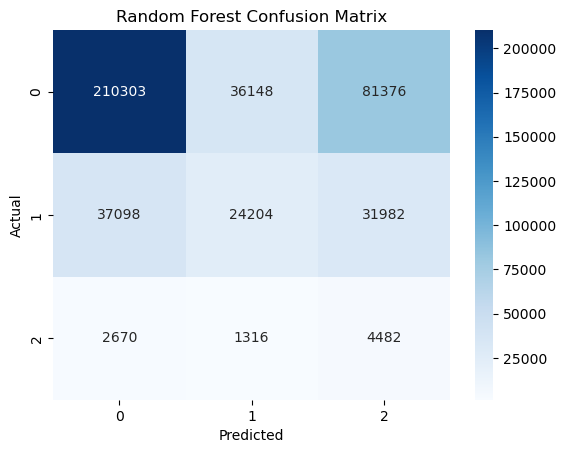

In [23]:
# Compute confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_best_rf)
print("Confusion Matrix: \n", cm_rf)

# Plot Confusion Matrix
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")

plt.show()

In [25]:
# --------------
# Decision Tree (randomized + SMOTE)
# --------------

import matplotlib.colors as mcolors

# Define parameter distribution for Random Search
param_dist = {
    "max_depth": np.arange(5, 30, 5),  # Increase upper limit
    "min_samples_leaf": np.arange(10, 100, 10),
    "criterion": ["gini", "entropy"],
}

# Initialize Decision Tree Classifier
tree = DecisionTreeClassifier(random_state=42)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    tree, param_dist, n_iter=20, cv=5, scoring="accuracy",
    n_jobs=-1, random_state=42, verbose=1
)

# Fit Randomized Search to training data
train_start = time.time()
random_search.fit(X_train_balanced, y_train_balanced)
train_end = time.time()
tree_training_time = train_end - train_start

# Get best model from Randomized Search
best_tree_clf = random_search.best_estimator_

# Print best hyperparameters and accuracy from CV
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy Score (CV):", random_search.best_score_)

# Make predictions on test data
pred_start = time.time()
y_pred_best_tree = best_tree_clf.predict(X_test)
pred_end = time.time()
tree_prediction_time = pred_end - pred_start

# Evaluate model performance
print("\nTest Accuracy:", accuracy_score(y_test, y_pred_best_tree))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best_tree))
print(f"Decision Tree Randomized Search Training time: {tree_training_time:.2f} seconds")
print(f"Prediction time: {tree_prediction_time:.2f} seconds")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'min_samples_leaf': 40, 'max_depth': 10, 'criterion': 'gini'}
Best Accuracy Score (CV): 0.46940038724917327

Test Accuracy: 0.5812737587265672

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.66      0.74    327827
           1       0.36      0.33      0.35     93284
           2       0.04      0.42      0.07      8468

    accuracy                           0.58    429579
   macro avg       0.42      0.47      0.39    429579
weighted avg       0.72      0.58      0.64    429579

Decision Tree Randomized Search Training time: 5.46 seconds
Prediction time: 0.10 seconds


Confusion Matrix: 
 [[215336  51791  60700]
 [ 37754  30791  24739]
 [  2959   1933   3576]]


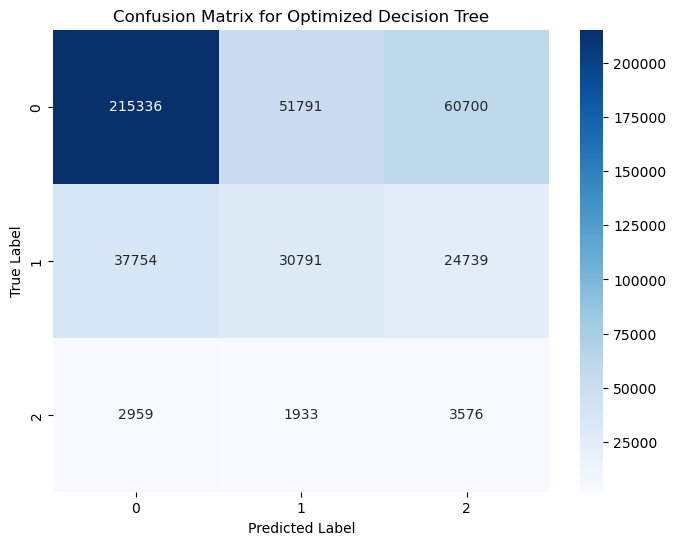

In [27]:
# Compute confusion matrix for Decision Tree
cm_tree = confusion_matrix(y_test, y_pred_best_tree)
print("Confusion Matrix: \n", cm_tree)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tree, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Optimized Decision Tree")

plt.show()

In [29]:
# --------------------------------------------------
# Baseline Model: Logistic Regression (Multinomial) (SMOTE)
# --------------------------------------------------

# Define the hyperparameter space
param_dist = {
    "C": np.logspace(-4, 4, 20),  # Regularization strength
    "penalty": ["l1", "l2"],       # Regularization type (only "l2" works with saga)
    "solver": ["liblinear", "saga"],  # Solvers suitable for l1 & l2 penalties
}

# Initialize the model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    log_reg, param_distributions=param_dist,
    n_iter=30,  # Number of different hyperparameter combinations to try
    cv=5,       # Cross-validation folds
    scoring="accuracy",
    n_jobs=-1,  # Use all CPU cores
    random_state=42,
    verbose=1
)

# Train the model with RandomizedSearchCV
train_start = time.time()
random_search.fit(X_train_balanced, y_train_balanced)
train_end = time.time()
rand_training_time = train_end - train_start

# Print the best parameters and accuracy
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy Score:", random_search.best_score_)

# Use the best model to predict on test data
best_log_reg = random_search.best_estimator_

pred_start = time.time()
y_pred_best_log = best_log_reg.predict(X_test)
pred_end = time.time()
rand_prediction_time = pred_end - pred_start

# Evaluate performance
print("\nTest Accuracy:", accuracy_score(y_test, y_pred_best_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best_log))
print(f"RandomSearch Training time: {rand_training_time:.2f} seconds")
print(f"Prediction time: {rand_prediction_time:.2f} seconds")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 1.623776739188721}
Best Accuracy Score: 0.42199782361544774

Test Accuracy: 0.4458434886249095

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.50      0.62    327827
           1       0.29      0.24      0.27     93284
           2       0.03      0.52      0.06      8468

    accuracy                           0.45    429579
   macro avg       0.38      0.42      0.31    429579
weighted avg       0.69      0.45      0.53    429579

RandomSearch Training time: 581.49 seconds
Prediction time: 0.07 seconds


In [ ]:
# ---------------------------------------
# Neural Network epochs = 100, early stop, class weight balanced
# ---------------------------------------

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # multi-class

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Train the model with class weights
start_train = time.time()
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=2048,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
end_train = time.time()


start_test = time.time()
predictions = model.predict(X_test_scaled)
nn_preds = np.argmax(predictions, axis=1)
end_test = time.time()


# Evaluate
print("Neural Network Accuracy:", accuracy_score(y_test, nn_preds))
print("Classification Report:\n", classification_report(y_test, nn_preds))
print("Neural Network Training Time: {:.2f} seconds".format(end_train - start_train))
print("Prediction Time: {:.2f} seconds".format(end_test - start_test))

C:\Users\saran\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
672/672 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4653 - loss: 1.0655 - val_accuracy: 0.5796 - val_loss: 0.9923 - learning_rate: 0.0010
Epoch 2/100
672/672 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5291 - loss: 1.0420 - val_accuracy: 0.5006 - val_loss: 1.0472 - learning_rate: 0.0010
Epoch 3/100
672/672 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5210 - loss: 1.0390 - val_accuracy: 0.5282 - val_loss: 1.0197 - learning_rate: 0.0010
Epoch 4/100
672/672 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5324 - loss: 1.0315 - val_accuracy: 0.5253 - val_loss: 1.0223 - learning_rate: 2.0000e-04
13425/13425 ━━━━━━━━━━━━━━━━━━━━ 9s 701us/step 
Neural Network Accuracy: 0.5783243594309778
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.67      0.74    327827
           1       0.36      0.26      0.30     93284
           2       0.04      0.42      0.07      8468

    accuracy                           0.58    429

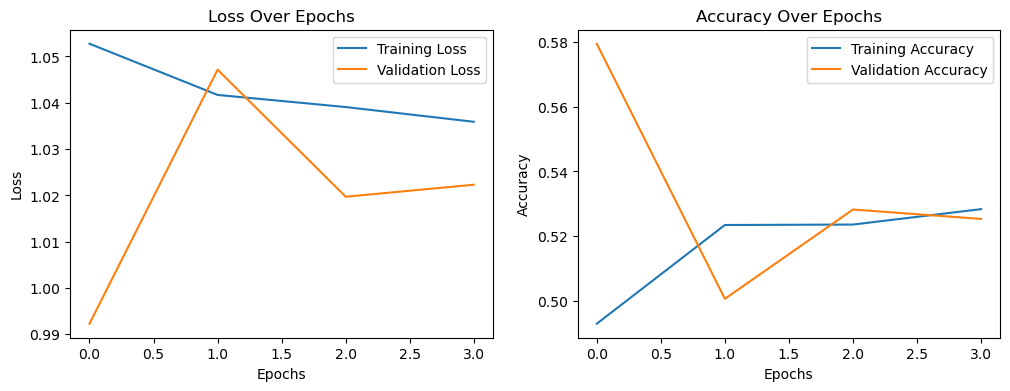

In [ ]:
import matplotlib.pyplot as plt

# Plot loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

13425/13425 ━━━━━━━━━━━━━━━━━━━━ 10s 758us/step


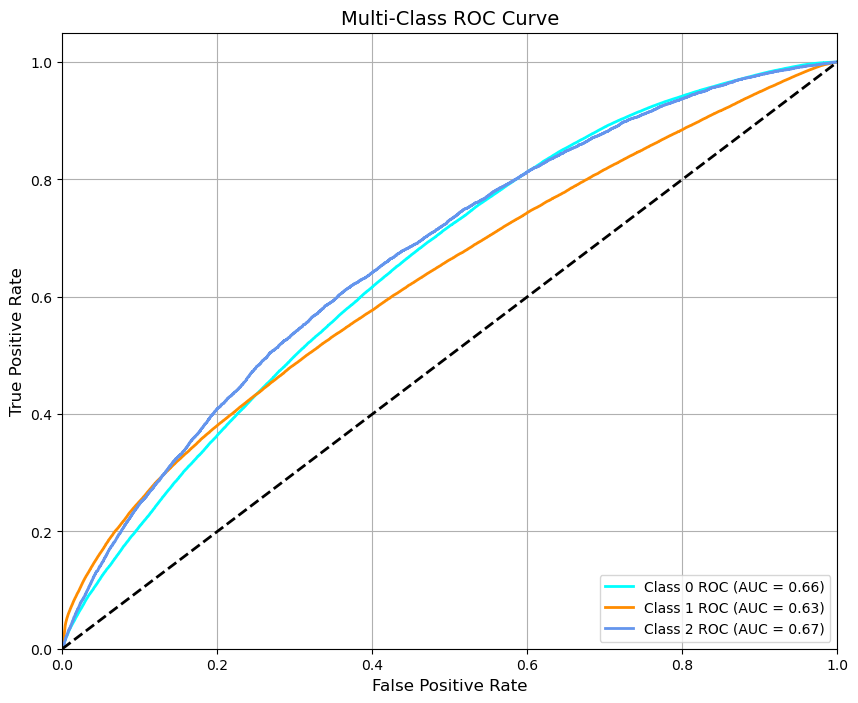

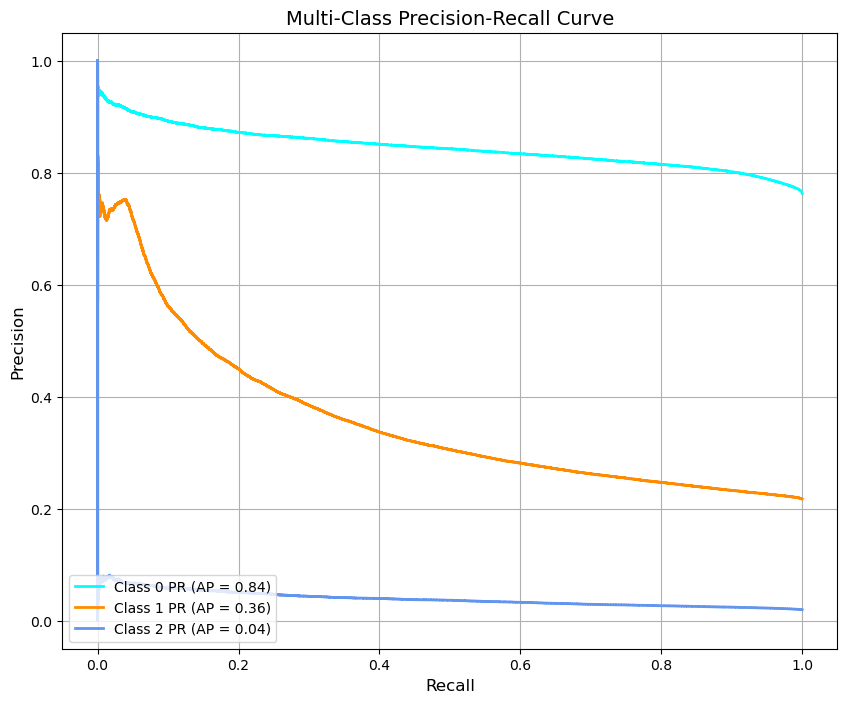

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Get predicted probabilities from model
y_score = model.predict(X_test_scaled)

# --- ROC-AUC Curves ---
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} ROC (AUC = {1:0.2f})'.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-Class ROC Curve', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.show()

# --- Precision-Recall Curves ---
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Class {0} PR (AP = {1:0.2f})'.format(classes[i], average_precision[i]))
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Multi-Class Precision-Recall Curve', fontsize=14)
plt.legend(loc="lower left", fontsize=10)
plt.grid(True)
plt.show()

In [ ]:
# ----------------------
# Neural Network (SMOTE)
# ----------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # multi-class

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Train the model with class weights
start_train = time.time()
history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_split=0.2,
    epochs=100,
    batch_size=2048,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
end_train = time.time()


start_test = time.time()
predictions = model.predict(X_test)
nn_preds = np.argmax(predictions, axis=1)
end_test = time.time()


# Evaluate
print("Neural Network (SMOTE) Accuracy:", accuracy_score(y_test, nn_preds))
print("Classification Report:\n", classification_report(y_test, nn_preds))
print("Neural Network (SMOTE) Training Time: {:.2f} seconds".format(end_train - start_train))
print("Prediction Time: {:.2f} seconds".format(end_test - start_test))

Epoch 1/100


C:\Users\saran\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3658 - loss: 6929.6250 - val_accuracy: 0.0000e+00 - val_loss: 5240.1084 - learning_rate: 0.0010
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3862 - loss: 2667.8347 - val_accuracy: 0.0059 - val_loss: 1484.0260 - learning_rate: 0.0010
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3846 - loss: 1544.8712 - val_accuracy: 0.0020 - val_loss: 1547.8553 - learning_rate: 0.0010
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3846 - loss: 972.6652 - val_accuracy: 0.0096 - val_loss: 637.5453 - learning_rate: 0.0010
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3797 - loss: 645.7993 - val_accuracy: 0.0000e+00 - val_loss: 919.6669 - learning_rate: 0.0010
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3876 - loss: 477.1887 - val_accuracy: 0.0000e+00 - val_loss: 790.5378 - learning_rate: 0.0010
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 

Confusion Matrix for NN:
 [[195302 128501   4024]
 [ 60104  32105   1075]
 [  6001   2381     86]]


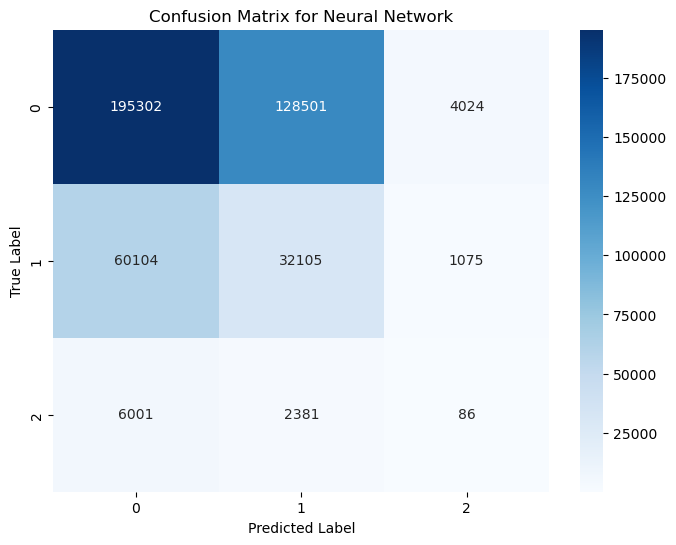

In [ ]:
# Compute confusion matrix for NN
cm_nn = confusion_matrix(y_test, nn_preds)
print("Confusion Matrix for NN:\n", cm_nn)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nn, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Neural Network")

plt.show()

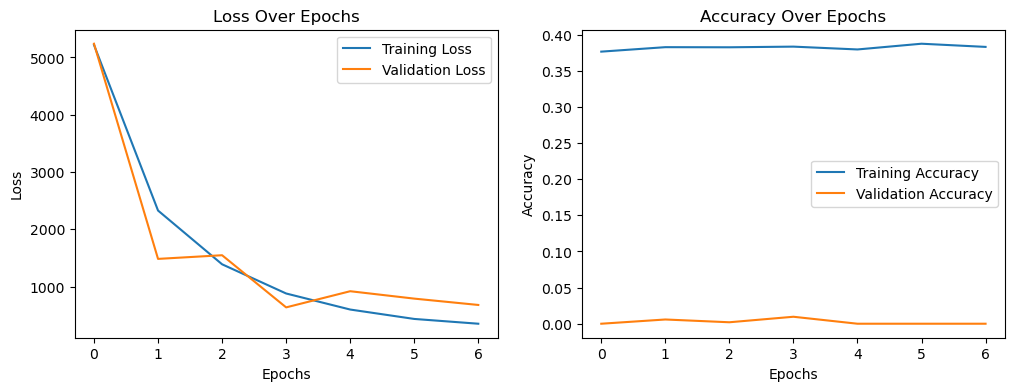

In [ ]:
# Plot loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

13425/13425 ━━━━━━━━━━━━━━━━━━━━ 11s 819us/step


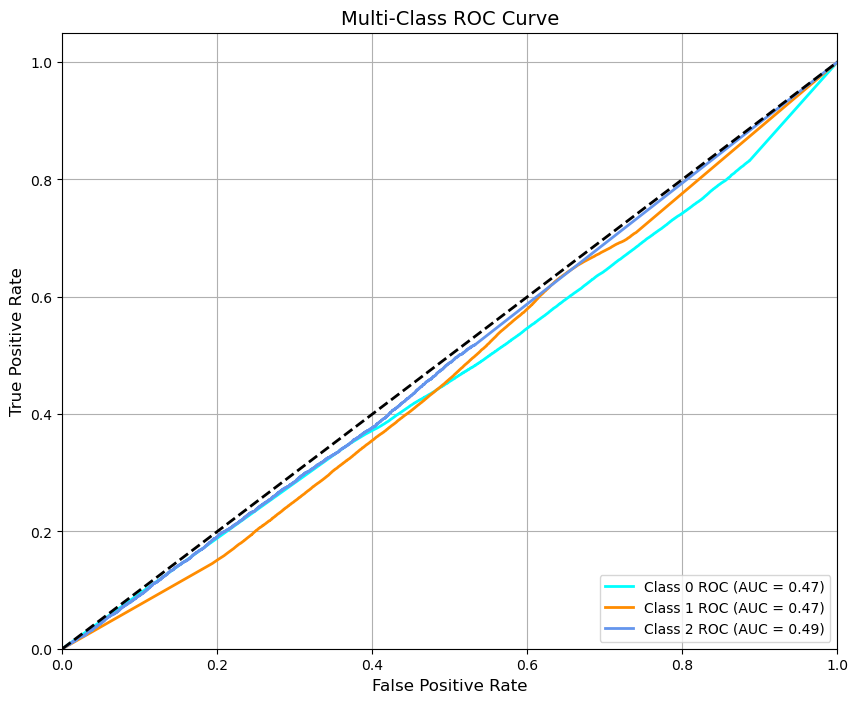

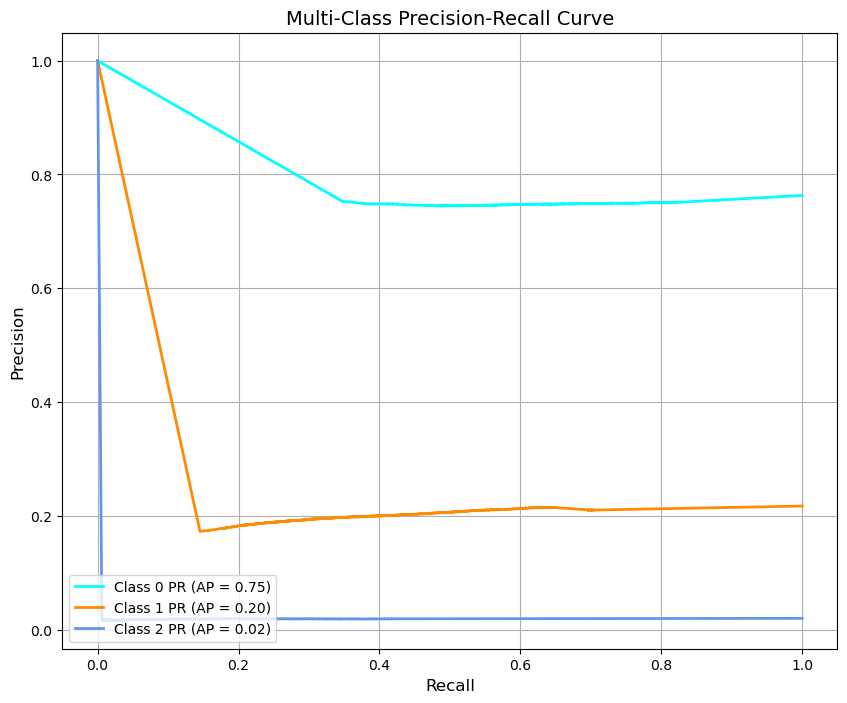

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Get predicted probabilities from model
y_score = model.predict(X_test)

# --- ROC-AUC Curves ---
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} ROC (AUC = {1:0.2f})'.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-Class ROC Curve', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.show()

# --- Precision-Recall Curves ---
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Class {0} PR (AP = {1:0.2f})'.format(classes[i], average_precision[i]))
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Multi-Class Precision-Recall Curve', fontsize=14)
plt.legend(loc="lower left", fontsize=10)
plt.grid(True)
plt.show()